In [1]:
#%matplotlib notebook
%matplotlib inline

# https://stackoverflow.com/questions/43599018/is-there-a-way-to-get-matplotlib-path-contains-points-to-be-inclusive-of-boundar
#I do quite like this command in Jupiter notebook:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
#It makes things wider and not waste the space on your screen
import pandas as pd
import importlib
import csv,os
import numpy as np
import pandas as pd
import itertools
import pyproj
import shapely
import copy
from uafgi import gicollections,cfutil,glacier,gdalutil,shputil,pdutil
import uafgi.data.ns642
import netCDF4
import matplotlib.pyplot as plt
import uafgi.data.wkt
import uafgi.data.w21 as d_w21
map_wkt = uafgi.data.wkt.nsidc_ps_north
pd.set_option("display.max_rows", 30, "display.max_columns", None)
pd.set_option("display.max_rows", 200, "display.max_columns", None)

from uafgi.data import d_velterm
import uafgi.data.stability as d_stability
import scipy

In [2]:
importlib.reload(d_velterm)
importlib.reload(d_stability)
select = d_stability.read_select(map_wkt)
velterm_df = d_velterm.read()



Index(['fj_fid', 'fj_poly', 'fj_key'], dtype='object')
Index(['ft_ftid', 'ft_terminus', 'ft_key'], dtype='object')


In [3]:
map_wkt = uafgi.data.wkt.nsidc_ps_north
select = d_stability.read_select(map_wkt)

Index(['fj_fid', 'fj_poly', 'fj_key'], dtype='object')
Index(['ft_ftid', 'ft_terminus', 'ft_key', 'fj_fid'], dtype='object')


In [5]:
select.df.columns

Index(['w21t_Glacier', 'w21t_date_termini', 'w21t_glacier_number', 'w21t_tloc',
       'w21_popular_name', 'w21_greenlandic_name', 'w21_coast', 'w21_category',
       'w21_Qr', 'w21_Qf', 'w21_Qm', 'w21_Qs', 'w21_Qc_inferred', 'w21_qm',
       'w21_qf', 'w21_qc', 'w21_mean_depth', 'w21_min_depth',
       'w21_quality_str', 'w21_area_grounded_1992_2017',
       'w21_area_grounded_1992_1997', 'w21_area_grounded_1998_2007',
       'w21_area_grounded_2008_2017', 'w21_mean_fjord_width',
       'w21_length_grounded_1992_2017', 'w21_length_grounded_1992_1997',
       'w21_length_grounded_1998_2007', 'w21_length_grounded_2008_2017',
       'w21_ocean_model_sample_area', 'w21_mean_TF_1992-2017',
       'w21_mean_TF_1992-1997', 'w21_mean_TF_1998-2007',
       'w21_mean_TF_2008-2017', 'w21_subglacial_discharge_1992_2017',
       'w21_subglacial_discharge_1992_1997',
       'w21_subglacial_discharge_1998_2007',
       'w21_subglacial_discharge_2008_2017', 'w21_mean_xsection_area',
       'w21_mean_

In [61]:
def _selcols(select, y0, y1):
    y_end = y1-1
    Qsg_name = f'w21_subglacial_discharge_{y0:04d}_{y_end:04d}'
    TF_name = f'w21_mean_TF_{y0:04d}-{y_end:04d}'
        
    df0 = select.df[[
        'w21t_Glacier', 'w21t_glacier_number', 'w21_coast', 'w21_mean_fjord_width',
        Qsg_name, TF_name]]
    df0 = df0.rename(columns={Qsg_name:'Qsg', TF_name:'TF'})
    df0['q4tf'] = df0['Qsg']**0.4 * df0['TF']
    df0['year0'] = float(y0)
    df0['year1'] = float(y1)
    return df0


dfs = list()
for y0,y1 in ((1992,1998), (1998,2008), (2008,2018)):
    df = _selcols(select, y0,y1)
    dfs.append(df)
df = pd.concat(dfs)

#df0 = _selcols(select, 1992, 1998)#'w21_subglacial_discharge_1998_2007', 'w21_mean_TF_1998-2007')
#df1 = _selcols(select, 'w21_subglacial_discharge_2008_2017', 'w21_mean_TF_2008-2017')

#df = pd.concat((df0,df1)).sort_values('w21t_Glacier')
# See Estimating Greenland tidewater glacier retreat driven by submarine melting (Slater et al 2019) p. 2497
wdfs = [df[df.w21_coast.isin(['SE','SW','CE','CW','NE'])],  df[df.w21_coast.isin(['N','NW'])]]
wdfs[0]

,w21t_Glacier,w21t_glacier_number,w21_coast,w21_mean_fjord_width,Qsg,TF,q4tf,year0,year1
0,AP Bernstorff,62,SE,3.70,1.72,1.97,2.447246,1992.0,1998.0
2,Akullersuup,21,SW,3.30,1.52,6.09,7.200369,1992.0,1998.0
6,Alangorliup,18,CW,2.51,2.91,2.70,4.139243,1992.0,1998.0
8,Anorituup Kangerlua N,43,SE,2.30,3.14,4.67,7.380550,1992.0,1998.0
9,Apuseerajik,82,SE,2.74,4.71,6.59,12.248807,1992.0,1998.0
13,Christian IV,104,CE,8.38,6.96,1.32,2.868254,1992.0,1998.0
16,Danell,38,SE,1.99,2.48,2.08,2.991190,1992.0,1998.0
17,Danell S,37,SE,1.25,0.61,2.56,2.100738,1992.0,1998.0
18,Daugaard Jensen,126,CE,5.23,5.15,1.47,2.831654,1992.0,1998.0
19,Deception O CN,94,CE,3.48,1.57,4.64,5.557479,1992.0,1998.0


In [74]:
# Read year,up_len from Wood et al data
rdfs = list()

year_bounds = [1992,]

for _,selrow in select.df.iterrows():
    with netCDF4.Dataset(os.path.join('data', 'wood2021', 'data', selrow['w21_data_fname'])) as nc:
        grp = nc.groups['ice_front_retreat']['discrete']
        retreat_time = grp.variables['retreat_time'][:].astype(np.float64)
        retreat = grp.variables['retreat'][:]
        retreat -= np.mean(retreat)   # Retreat is compared to average; zero point doesn't really matter
        rdf = pd.DataFrame({'year':retreat_time, 'up_len':-retreat})
        rdf['w21t_glacier_number'] = selrow.w21t_glacier_number
    rdfs.append(rdf)

rdf = pd.concat(rdfs)
rdf.year.dtype

dtype('float64')

In [158]:
# Join rdf (year,up_len) to appropriate row of q4tf
# https://pandas.pydata.org/pandas-docs/version/0.20/generated/pandas.merge_asof.html#pandas.merge_asof
for wdf in wdfs:
    wdf = wdf.sort_values('year0')
    rdf = rdf.sort_values('year')
    mdf = pd.merge_asof(rdf,wdf,left_on='year',right_on='year0', by=['w21t_glacier_number'])
    mdf = mdf.dropna()
    
    # Get just 1 point per decade
    dfg = mdf.groupby(['w21t_Glacier', 'w21t_glacier_number','year0','year1'])
    mdf = dfg.mean()
    mdf = mdf.reset_index()
#    break
mdf

,w21t_Glacier,w21t_glacier_number,year0,year1,year,up_len,w21_mean_fjord_width,Qsg,TF,q4tf
0,Academy,142,1992.0,1998.0,1993.599121,1.304410,8.24,2.77,0.41,0.616277
1,Academy,142,1998.0,2008.0,2003.436664,-0.070060,8.24,4.98,1.04,1.976629
2,Academy,142,2008.0,2018.0,2013.327202,-0.867214,8.24,5.86,1.86,3.772871
3,Akullikassaap,220,1992.0,1998.0,1993.962219,0.319650,1.58,0.29,2.77,1.688259
4,Akullikassaap,220,1998.0,2008.0,2003.173126,-0.090902,1.58,0.41,3.34,2.338083
5,Akullikassaap,220,2008.0,2018.0,2012.371928,-0.421005,1.58,0.48,3.92,2.922689
6,Akullikassaap E,221,1992.0,1998.0,1994.158366,0.710813,1.72,0.20,2.65,1.392060
7,Akullikassaap E,221,1998.0,2008.0,2003.057999,0.205095,1.72,0.26,3.02,1.761961
8,Akullikassaap E,221,2008.0,2018.0,2014.167419,-1.179803,1.72,0.30,3.36,2.075811
9,Akullikassaap W,219,1992.0,1998.0,1994.158366,0.268238,1.49,0.17,2.61,1.284754


-0.48361878403700037


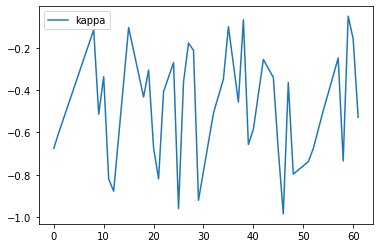

In [159]:
#### This is the one that is good.

import statsmodels.api
import statsmodels.formula.api
dfg = mdf.groupby(['w21t_Glacier','w21t_glacier_number'])
kappas = list()
for _,df in dfg:
    results = statsmodels.formula.api.ols('up_len ~ q4tf', data=df).fit()
    #print(results.summary())
    kappa = results.params.q4tf   # Kappa named after regression in paper
    kappas.append(kappa)
##    #lr = sklearn.liear_model.LinearRegression()
 #   lr.fit()
#    print(df)
#    df.plot.scatter('q4tf','up_len')
kappas = np.array(kappas)
df = pd.DataFrame({'kappa':kappas})
df = df[df.kappa.abs()<1]
df.plot()
print(df.kappa.mean())


In [94]:
import sklearn

                            OLS Regression Results                            
Dep. Variable:                 up_len   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.071
Date:                Fri, 03 Dec 2021   Prob (F-statistic):              0.303
Time:                        18:44:13   Log-Likelihood:                -264.49
No. Observations:                 122   AIC:                             533.0
Df Residuals:                     120   BIC:                             538.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.3147      0.310     -4.245      0.0

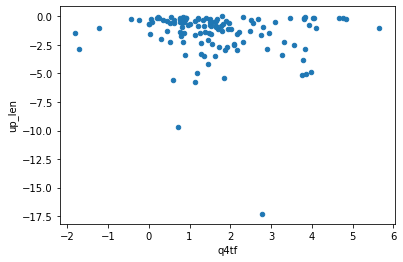

In [157]:
mdf0 = mdf[mdf.year0 == 1992.0][['w21t_glacier_number','up_len','q4tf']].rename(columns={'up_len':'up_len0', 'q4tf':'q4tf0'})
mdf1 = mdf[mdf.year0 != 1992.0]
dmdf = pd.merge(mdf1,mdf0,on='w21t_glacier_number',how='left')
dmdf['up_len'] = dmdf['up_len'] - dmdf['up_len0']
dmdf['q4tf'] = dmdf['q4tf'] - dmdf['q4tf0']
dmdf = dmdf[['w21t_Glacier','w21t_glacier_number','year0','year1','q4tf','up_len']]
dmdf
dmdf.plot.scatter('q4tf','up_len')
results = statsmodels.formula.api.ols('up_len ~ q4tf', data=dmdf).fit()
print(results.summary())